# **Clustering/Churn Prediction Analysis**


In churn prediction, we assume that there are three phases of customer lifecycle :

*   The ‘good’ phase [Month 6 & 7]
*   The ‘action’ phase [Month 8]
*   The ‘churn’ phase [Month 9]

In this case, since we are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.



In [ ]:
## imports
import pandas as pd
import numpy as np
import os
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from imblearn.over_sampling import SMOTE
from scipy.cluster.hierarchy import dendrogram , linkage
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA ,IncrementalPCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
#from jqmcvi import base

import pickle

## Config
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
pd.options.display.float_format = "{:.2f}".format

# Suppressing Warnings
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


---
## **1. Load Dataset :**



In [ ]:
# Load Data
df = pd.read_csv("telecom_churn_dataset.csv",index_col="index")

In [ ]:
print("Data dimentions : {}".format(df.shape))
df.info()

Data dimentions : (99999, 234)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99998
Columns: 234 entries, mobile_number to sms_og_9
dtypes: float64(179), int64(43), object(12)
memory usage: 179.3+ MB


In [ ]:
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,sms_ic_6,sms_ic_7,sms_ic_8,sms_og_6,sms_og_7,sms_og_8,sms_ic_9,sms_og_9
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,214.82,213.80,21.10,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,na

In [ ]:
"""
df['sms_ic_6'] = np.random.randint(0, 42, df.shape[0])
df['sms_ic_7'] = np.random.randint(0, 30, df.shape[0])
df['sms_ic_8'] = np.random.randint(0, 25, df.shape[0])
df['sms_ic_9'] = np.random.randint(0, 15, df.shape[0])
df['sms_og_6'] = np.random.randint(0, 37, df.shape[0])
df['sms_og_7'] = np.random.randint(0, 26, df.shape[0])
df['sms_og_8'] = np.random.randint(0, 23, df.shape[0])
df['sms_og_9'] = np.random.randint(0, 12, df.shape[0])
df.to_csv('/content/drive/My Drive/[PFE]/Colab Notebooks/telecom_churn_dataset.csv')
"""

"\ndf['sms_ic_6'] = np.random.randint(0, 42, df.shape[0])\ndf['sms_ic_7'] = np.random.randint(0, 30, df.shape[0])\ndf['sms_ic_8'] = np.random.randint(0, 25, df.shape[0])\ndf['sms_ic_9'] = np.random.randint(0, 15, df.shape[0])\ndf['sms_og_6'] = np.random.randint(0, 37, df.shape[0])\ndf['sms_og_7'] = np.random.randint(0, 26, df.shape[0])\ndf['sms_og_8'] = np.random.randint(0, 23, df.shape[0])\ndf['sms_og_9'] = np.random.randint(0, 12, df.shape[0])\ndf.to_csv('/content/drive/My Drive/[PFE]/Colab Notebooks/telecom_churn_dataset.csv')\n"

---
## **2. Data Exploration**

### **Incoming & Outgoing Calls**

#### **ONNET & OFFNET Calls**

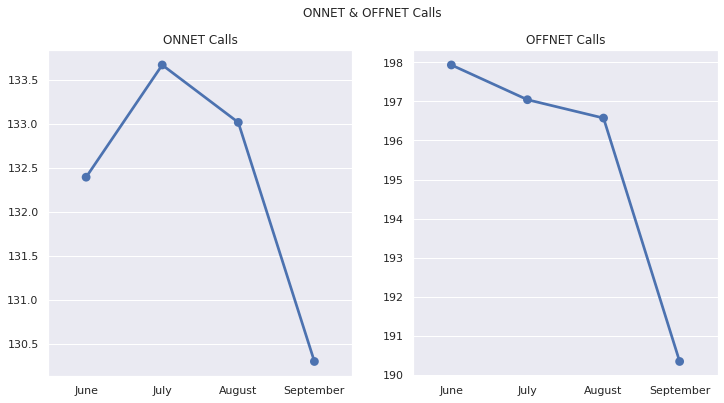

In [ ]:
offnet = df[['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'offnet_mou_9']].mean()
onnet = df[['onnet_mou_6','onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9' ]].mean()
months = ['June', 'July', 'August', 'September']
fig, axes = plt.subplots(1,2, figsize = (12,6))
calls = [onnet,offnet]
fig.suptitle('ONNET & OFFNET Calls')
title= ['ONNET Calls','OFFNET Calls']
for i, type in enumerate(calls):
    ax = sns.pointplot(months, type, ax = axes[i])
    ax.set_title(title[i])
plt.show()



#### **Incoming & Outgoing Calls**

In [ ]:
local_ic_call = list(df[['loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_mou_9']].mean())
local_og_call = list(df[['loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'loc_og_mou_9']].mean())
std_ic_call = list(df[['std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'std_ic_mou_9']].mean())
std_og_call = list(df[['std_og_mou_6', 'std_og_mou_7' , 'std_og_mou_8', 'std_og_mou_9']].mean())
isd_ic_call = list(df[['isd_ic_mou_6','isd_ic_mou_7', 'isd_ic_mou_8', 'isd_ic_mou_9' ]].mean())
isd_og_call = list(df[['isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'isd_og_mou_9']].mean())

incomingcalls = pd.DataFrame({'months': months, 'local_call':local_ic_call, 'std_call': std_ic_call, 'isd_call': isd_ic_call})
outgoingcalls = pd.DataFrame({'months': months, 'local_call': local_og_call, 'std_call': std_og_call, 'isd_call': isd_og_call})
incomingcalls = incomingcalls.melt('months', var_name=  'cols', value_name =  'vals')
outgoingcalls = outgoingcalls.melt('months', var_name = 'cols', value_name = 'vals')

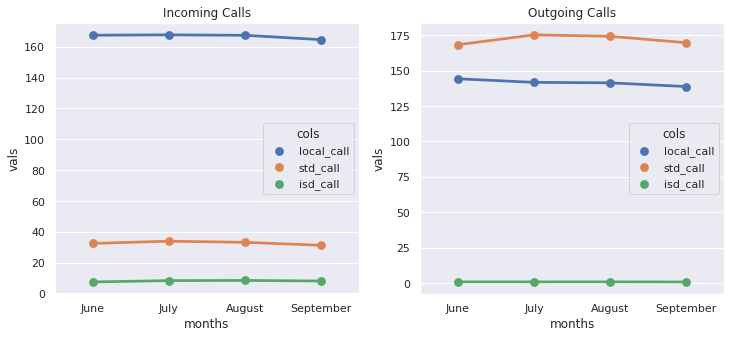

In [ ]:
calltype = [incomingcalls, outgoingcalls]
fig , axes = plt.subplots(1,2, figsize = (12,5))
title = ['Incoming Calls', 'Outgoing Calls']
for i,values in enumerate(calltype):
    ax = sns.pointplot(x = 'months', y = 'vals', hue = 'cols', data = values, ax = axes[i])
    ax.set_title(title[i])
plt.show()

#### **Roaming Calls**

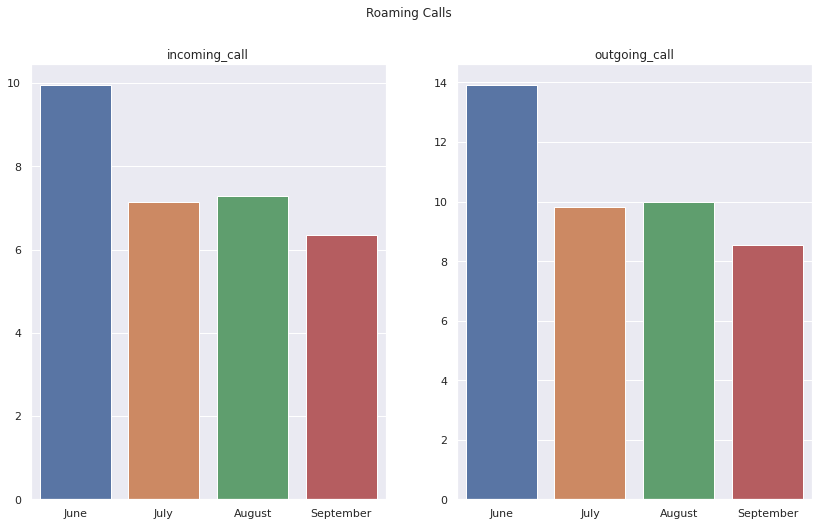

In [ ]:
incoming_roaming = df[['roam_ic_mou_6' , 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9']].mean()
outgoing_roaming = df[['roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'roam_og_mou_9']].mean()
fig,axes = plt.subplots(1,2,figsize = (14,8))
fig.suptitle('Roaming Calls')
roaming_call = [incoming_roaming, outgoing_roaming]
title = ['incoming_call', 'outgoing_call']
for i,call in enumerate(roaming_call):
    ax = sns.barplot(months , y = call, ax = axes[i])
    ax.set_title(title[i])
plt.show()    

#### **SMS**

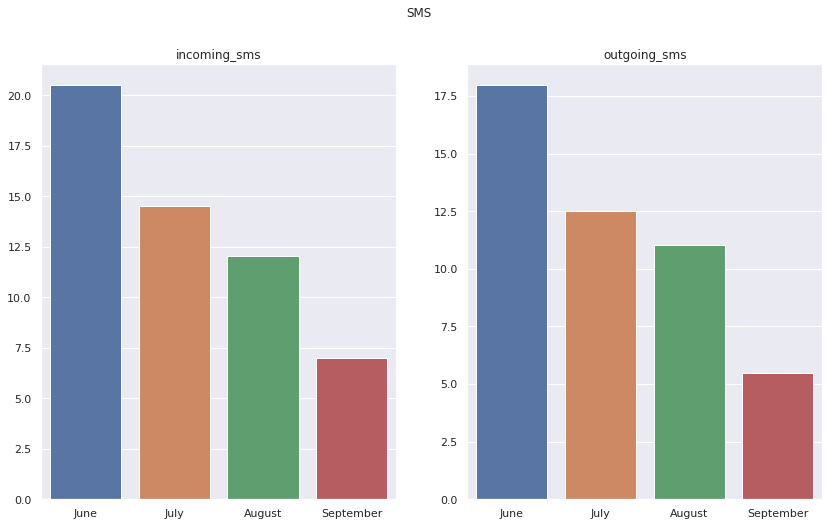

In [ ]:
incoming_roaming = df[['sms_ic_6' , 'sms_ic_7', 'sms_ic_8', 'sms_ic_9']].mean()
outgoing_roaming = df[['sms_og_6', 'sms_og_7', 'sms_og_8', 'sms_og_9']].mean()
fig,axes = plt.subplots(1,2,figsize = (14,8))
fig.suptitle('SMS')
roaming_call = [incoming_roaming, outgoing_roaming]
title = ['incoming_sms', 'outgoing_sms']
for i,call in enumerate(roaming_call):
    ax = sns.barplot(months , y = call, ax = axes[i])
    ax.set_title(title[i])
plt.show()    



---



---



### **Data Usage**

In [ ]:
column_names = list(df.columns)
data_volume = []
for i in column_names:
    if 'vol' in i:
        data_volume.append(i)
df['avg_volume'] = df[data_volume].mean(axis = 1)
No_Data_Usage = list(df['mobile_number'][df['avg_volume']==0])
Lowdata_users = list(df['mobile_number'][(df['avg_volume']>0) & (df['avg_volume'] <= 50)])
avgdata_users = list(df['mobile_number'][(df['avg_volume']> 50) & (df['avg_volume']<=85)])
highdata_users = list(df['mobile_number'][df['avg_volume']> 85])
df = df.drop(['avg_volume'],axis=1)

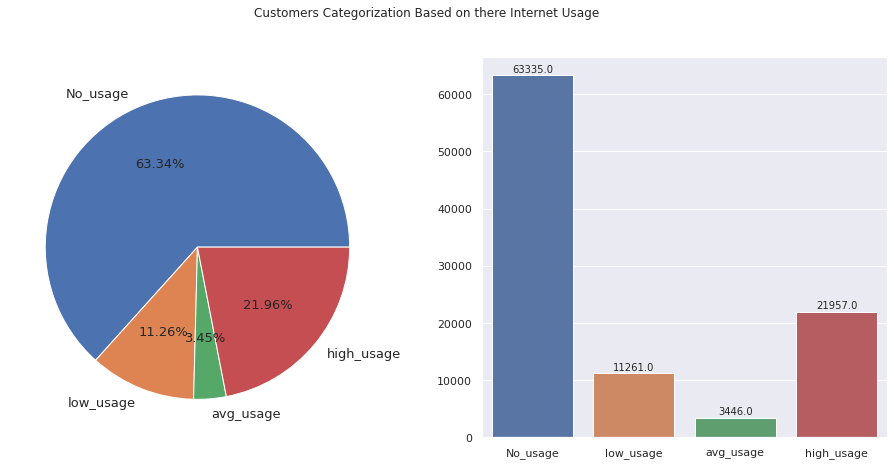

In [ ]:
No_usage = len(No_Data_Usage)
low_usage = len(Lowdata_users)
avg_usage = len(avgdata_users)
high_usage = len(highdata_users)
Internet_usage = [No_usage, low_usage, avg_usage, high_usage]
lab = ['No_usage', 'low_usage', 'avg_usage', 'high_usage']
fig, axes = plt.subplots(1,2, figsize = (16,7))
fig.suptitle('Customers Categorization Based on there Internet Usage')
axes[0].pie(Internet_usage, labels = lab, autopct = '%.2f%%', textprops = {'size': 13})
barp = sns.barplot(x = lab, y = Internet_usage, ax = axes[1])
for x in barp.patches:
    barp.annotate(format(x.get_height()),(x.get_x() + x.get_width()/2., x.get_height()),ha = 'center', va = 'center', xytext = (0,6), textcoords = 'offset points')

### **Customer age in service**

In [ ]:
df["aon"] = df["aon"] / (30)

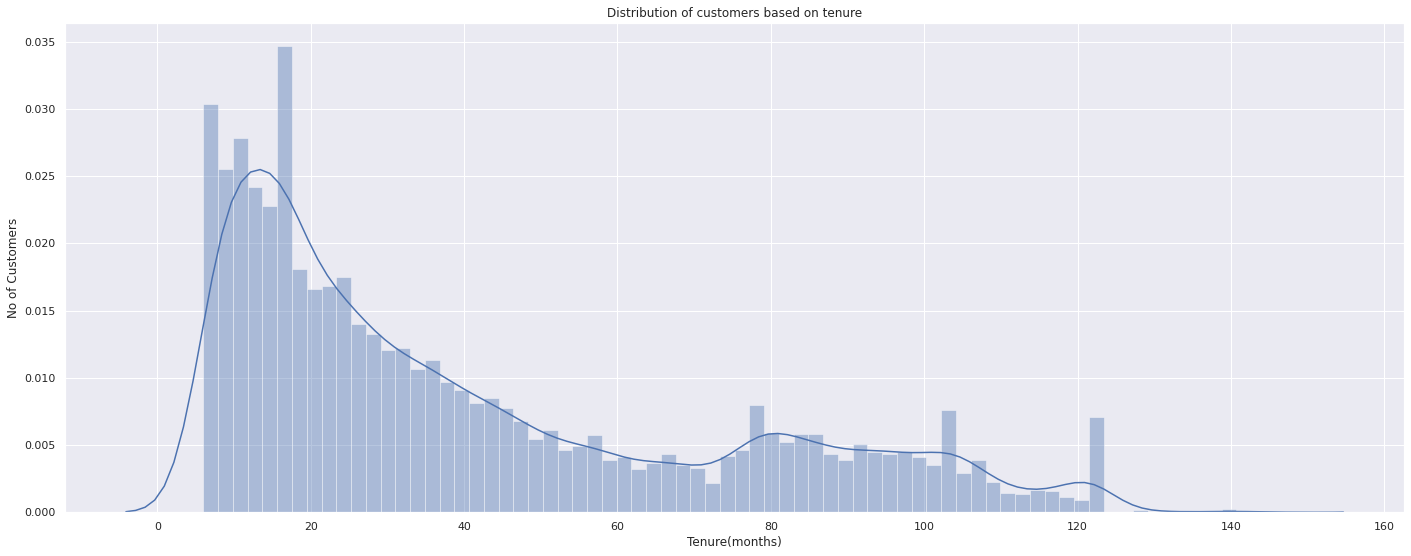

In [ ]:
plt.figure(figsize = (24,9))
sns.distplot(df['aon'],bins = int(df['aon'].max()/2), hist = True)
plt.xlabel('Tenure(months)')
plt.ylabel('No of Customers')
plt.title('Distribution of customers based on tenure')
plt.show()

---
## **3. Data Preparation :**

### **Rename Columns**

In [ ]:
months = {"jun":'_6',"aug":'_8',"jul":"_7","sep":"_8"}
for m in months:
  for col in df.columns :
    if m in col :
      c = col.replace(m+'_','') + months[m]
      df.rename(columns={col:c}, inplace=True)
      

### **Correct data format**

Check Columns that can be changed to integers, floats or other types

In [ ]:
df.dtypes.value_counts()

float64    180
int64       42
object      12
dtype: int64

In [ ]:
#Check for Columns that can be changed to integers, floats or other types
object_col_data = df.select_dtypes(include=['object'])
print(object_col_data.iloc[0])

last_date_of_month_6        6/30/2014
last_date_of_month_7        7/31/2014
last_date_of_month_8        8/31/2014
last_date_of_month_9        9/30/2014
date_of_last_rech_6         6/21/2014
date_of_last_rech_7         7/16/2014
date_of_last_rech_8          8/8/2014
date_of_last_rech_9         9/28/2014
date_of_last_rech_data_6    6/21/2014
date_of_last_rech_data_7    7/16/2014
date_of_last_rech_data_8     8/8/2014
date_of_last_rech_data_9          NaN
Name: 0, dtype: object


In [ ]:
# convert to datetime
for col in object_col_data.columns:
    df[col] = pd.to_datetime(df[col])

df.dtypes.value_counts()

float64           180
int64              42
datetime64[ns]     12
dtype: int64

### **Calculate Churn label**

9th month is considered to be testing phase where the customer is ready to churn. \
So we'll tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase.
- The attributes we need to use to tag churners are: ***total_ic_mou_9, total_og_mou_9, vol_2g_mb_9, vol_3g_mb_9***
- After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ ***_9’*** in their names).




In [ ]:
df['churn'] = df.loc[:,['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1)
df['churn'] = df['churn'].apply(lambda x: 0 if x > 0 else 1)

0    89808
1    10191
Name: churn, dtype: int64


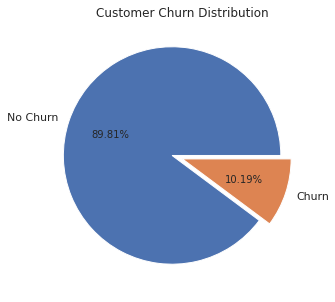

In [ ]:
print(df['churn'].value_counts())

churn_values = list(df['churn'].value_counts())
lab = ['No Churn', 'Churn']
plt.figure(figsize = (7,5))
plt.pie(churn_values, labels = lab, explode = (0.1, 0), autopct = "%.2f%%")
plt.title('Customer Churn Distribution')
plt.show()

#### **Remove All 9th Month related columns**

In [ ]:
#Remove All 9th Month related columns
drop_cols = [col for col in df.columns if '_9' in col]
print(drop_cols)

['last_date_of_month_9', 'arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9', 'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'arpu_2g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9', 'sms_ic_9', 'sms_og_9']


In [ ]:
df = df.drop(drop_cols, axis=1)
df.shape

(99999, 179)

### **Features engineering**

#### **Handle "Date" columns**

In [ ]:
# Create "days_since_last_rech_" & "days_since_last_rech_data_"
df["days_since_last_rech_6"] = df["last_date_of_month_6"] - df["date_of_last_rech_6"]
df["days_since_last_rech_7"] = df["last_date_of_month_7"] - df["date_of_last_rech_7"]
df["days_since_last_rech_8"] = df["last_date_of_month_8"] - df["date_of_last_rech_8"]
df["days_since_last_rech_data_6"] = df["last_date_of_month_6"] - df["date_of_last_rech_data_6"]
df["days_since_last_rech_data_7"] = df["last_date_of_month_7"] - df["date_of_last_rech_data_7"]
df["days_since_last_rech_data_8"] = df["last_date_of_month_8"] - df["date_of_last_rech_data_8"]


In [ ]:
# drop the columns "last_date_of_month_" & "date_of_last_rech_"
df.drop(["last_date_of_month_6","last_date_of_month_7","last_date_of_month_8","date_of_last_rech_6","date_of_last_rech_7","date_of_last_rech_8","date_of_last_rech_data_6","date_of_last_rech_data_7","date_of_last_rech_data_8"],axis=1,inplace=True)

In [ ]:
# Replace NaNs values in "days_since_last_rech_" with 60 
maxi = 60

days_since_last_rech = ["days_since_last_rech_6","days_since_last_rech_7","days_since_last_rech_8"]
df[days_since_last_rech] = df[days_since_last_rech].fillna(pd.Timedelta(days=maxi))

days_since_last_rech_data = ["days_since_last_rech_data_6","days_since_last_rech_data_7","days_since_last_rech_data_8"]
df[days_since_last_rech_data] = df[days_since_last_rech_data].fillna(pd.Timedelta(days=maxi))

In [ ]:
#Convert Date types to numiric values
df[ days_since_last_rech + days_since_last_rech_data ] = df[ days_since_last_rech + days_since_last_rech_data ].astype(int) / (24*3600000000000)
df.dtypes.value_counts()

float64    143
int64       33
dtype: int64

In [ ]:
df.shape

(99999, 176)

#### **Drop columns with a single value :**

In [ ]:
# Columns with a single value
col_list = df.loc[:,df.apply(pd.Series.nunique) == 1]
col_list.head(3)

,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8
index,,,,,,,,,,
0,109,0.00,0.00,0.00,nan,nan,0.00,nan,nan,0.00
1,109,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,109,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
# Drop Columns with a single value
df = df.drop(col_list.columns,axis=1)
df.shape

(99999, 166)

#### **Deal with missing data**

##### **Check for null values :**

Check missing values pencentage (%) in each column

In [ ]:
# Check missing values pencentage (%) in each column
col_with_null = df.isnull().sum()
col_with_null[col_with_null >0] *100 / df.shape[0]

onnet_mou_6           3.94
onnet_mou_7           3.86
onnet_mou_8           5.38
offnet_mou_6          3.94
offnet_mou_7          3.86
offnet_mou_8          5.38
roam_ic_mou_6         3.94
roam_ic_mou_7         3.86
roam_ic_mou_8         5.38
roam_og_mou_6         3.94
roam_og_mou_7         3.86
roam_og_mou_8         5.38
loc_og_t2t_mou_6      3.94
loc_og_t2t_mou_7      3.86
loc_og_t2t_mou_8      5.38
loc_og_t2m_mou_6      3.94
loc_og_t2m_mou_7      3.86
loc_og_t2m_mou_8      5.38
loc_og_t2f_mou_6      3.94
loc_og_t2f_mou_7      3.86
loc_og_t2f_mou_8      5.38
loc_og_t2c_mou_6      3.94
loc_og_t2c_mou_7      3.86
loc_og_t2c_mou_8      5.38
loc_og_mou_6          3.94
loc_og_mou_7          3.86
loc_og_mou_8          5.38
std_og_t2t_mou_6      3.94
std_og_t2t_mou_7      3.86
std_og_t2t_mou_8      5.38
std_og_t2m_mou_6      3.94
std_og_t2m_mou_7      3.86
std_og_t2m_mou_8      5.38
std_og_t2f_mou_6      3.94
std_og_t2f_mou_7      3.86
std_og_t2f_mou_8      5.38
std_og_mou_6          3.94
s

##### **Fill NaNs values in recharge related columns with 0**

In [ ]:
rech_cols = [col for col in df.columns if 'rech' in col]
print(rech_cols)

['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'days_since_last_rech_6', 'days_since_last_rech_7', 'days_since_last_rech_8', 'days_since_last_rech_data_6', 'days_since_last_rech_data_7', 'days_since_last_rech_data_8']


In [ ]:
df[rech_cols] = df[rech_cols].fillna(0)

##### **Drop Columns for which 70% of the data in NULL**

In [ ]:
col_to_drop = df.loc[:,list((100*(df.isnull().sum()/len(df.index)) > 70))].columns
print(col_to_drop)

Index(['arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8'], dtype='object')


In [ ]:
df = df.drop(col_to_drop, axis=1)
df.shape

(99999, 154)

##### **Drop Rows which have more than 7 NANs**

In [ ]:
df.loc[df.isnull().sum(axis=1) > 7].shape

(8814, 154)

In [ ]:
df = df.loc[df.isnull().sum(axis=1) <= 7]
df.shape

(91185, 154)

##### **Check if there is still NaNs values**

In [ ]:
df.columns[df.isnull().sum() > 0]

Index([], dtype='object')

#### **drop inactive customers**

In [ ]:
total_rech_amt = df[['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8','total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8']]
df['sum_rech_amt'] = total_rech_amt.sum(axis = 1)

df[df['sum_rech_amt']==0].shape

(444, 155)

In [ ]:
df = df.loc[df['sum_rech_amt']!=0]
df = df.drop(["sum_rech_amt"], axis=1)
df.shape

(90741, 154)

In [ ]:
onnet = [col for col in df.columns if "onnet" in col]
onnet = df[onnet]
df['onnet'] = onnet.sum(axis = 1)

offnet = [col for col in df.columns if "offnet" in col]
offnet = df[offnet]
df['offnet'] = offnet.sum(axis = 1)

df[(df['onnet']==0) & (df['offnet']==0) ].shape

(532, 156)

In [ ]:
df = df.loc[(df['onnet']!=0) & (df['offnet']!=0)]
df = df.drop(["onnet","offnet"], axis=1)
df.shape

(88410, 154)

#### **Identify high value customers (not applicable)**

In [ ]:
avg_rech = (df.total_rech_amt_6 + df.total_rech_amt_7 + df.total_rech_amt_8) / 3
hign_cust = df.loc[avg_rech > avg_rech.quantile(.6)]
hign_cust.shape

(35328, 154)

In [ ]:
low_cust = df.loc[avg_rech <= avg_rech.quantile(.6)]
low_cust = low_cust[low_cust.churn==1]
low_cust.shape

(3416, 154)

In [ ]:
#df = df.loc[avg_rech > avg_rech.quantile(.6)]
df = pd.concat([hign_cust,low_cust],axis=0).sample(frac=1)
df.shape

(38744, 154)

#### **Drop irrelavant columns**

In [ ]:
# display all columns of each month
cols_6 = [col for col in df.columns if "_6" in col]
cols_6

['arpu_6',
 'onnet_mou_6',
 'offnet_mou_6',
 'roam_ic_mou_6',
 'roam_og_mou_6',
 'loc_og_t2t_mou_6',
 'loc_og_t2m_mou_6',
 'loc_og_t2f_mou_6',
 'loc_og_t2c_mou_6',
 'loc_og_mou_6',
 'std_og_t2t_mou_6',
 'std_og_t2m_mou_6',
 'std_og_t2f_mou_6',
 'std_og_mou_6',
 'isd_og_mou_6',
 'spl_og_mou_6',
 'og_others_6',
 'total_og_mou_6',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2f_mou_6',
 'loc_ic_mou_6',
 'std_ic_t2t_mou_6',
 'std_ic_t2m_mou_6',
 'std_ic_t2f_mou_6',
 'std_ic_mou_6',
 'total_ic_mou_6',
 'spl_ic_mou_6',
 'isd_ic_mou_6',
 'ic_others_6',
 'total_rech_num_6',
 'total_rech_amt_6',
 'max_rech_amt_6',
 'last_day_rch_amt_6',
 'total_rech_data_6',
 'max_rech_data_6',
 'count_rech_2g_6',
 'count_rech_3g_6',
 'av_rech_amt_data_6',
 'vol_2g_mb_6',
 'vol_3g_mb_6',
 'monthly_2g_6',
 'sachet_2g_6',
 'monthly_3g_6',
 'sachet_3g_6',
 'vbc_3g_6',
 'sms_ic_6',
 'sms_og_6',
 'days_since_last_rech_6',
 'days_since_last_rech_data_6']

In [ ]:
# drop irrelevent columns
loc = [col for col in df.columns if "loc" in col]
std = [col for col in df.columns if "std" in col]
df = df.drop(std,axis=1)
df = df.drop(loc,axis=1)

col_drop = ['isd_og_mou','spl_og_mou','spl_ic_mou','isd_ic_mou','og_others','ic_others','sachet_2g','sachet_3g','vbc_3g','max_rech_data','max_rech_amt','last_day_rch_amt']
for col in col_drop :
  col_6 = col+"_6"
  col_7 = col+"_7"
  col_8 = col+"_8"
  df = df.drop([col_6,col_7,col_8],axis=1)

df.shape

(38744, 66)

In [ ]:
# join 2g & 3g columns
internet_cols = [col for col in df.columns if "2g" in col]
for col2g in internet_cols:
  col3g = col2g.replace("2g_","3g_")
  col = col2g.split('_')[0] + "_2g3g"
  df[col] = df[[col2g,col3g]].mean(axis=1)
  df = df.drop([col2g,col3g],axis=1)

df.shape

(38744, 51)

#### **Export Columns**

In [ ]:
allCol = df.columns.values
np.savetxt("AllColumns.csv", allCol, fmt="%5s",delimiter=",")
colOfMonth = [col for col in df.columns if "_6" in col]
np.savetxt("columnsOfMonth.csv", colOfMonth, fmt="%5s",delimiter=",")

#### **Export dataSet**

In [ ]:
sample = df.loc[:10,:]
sample.to_csv("prepared_dataset_sample.csv", index=False)

In [ ]:
df.to_csv("prepared_dataset.csv", index=False)

In [ ]:
data = df.copy()
df = df.drop(["mobile_number"], axis=1)

---
## **5. Segmentation**

### **Feature reduction**

Merge month 6,7,8 columns (it contains the same behaivior)

In [ ]:
df_seg = df.copy()
cols_6 = [col for col in df_seg.columns if "_6" in col]

In [ ]:
for col in cols_6 :
  col = col[:-2]
  avg_col_name = col+"_avg"
  col_6 = col+"_6"
  col_7 = col+"_7"
  col_8 = col+"_8"
  df_seg[avg_col_name] = df_seg.loc[:,[col_6,col_7,col_8]].mean(axis=1)
  df_seg = df_seg.drop([col_6,col_7,col_8],axis=1)

df_seg.shape

(38744, 20)

In [ ]:
'''
loc_og = [col for col in df_seg.columns if "loc_og" in col]
print(loc_og)
df_seg["loc_og_avg"] = df_seg.loc[:,loc_og].mean(axis=1)
df_seg = df_seg.drop(loc_og,axis=1)
df_seg.shape
loc_ic = [col for col in df_seg.columns if "loc_ic" in col]
df_seg["loc_ic_avg"] = df_seg.loc[:,loc_ic].mean(axis=1)
df_seg = df_seg.drop(loc_ic,axis=1)
df_seg.shape
std_og = [col for col in df_seg.columns if "std_og" in col]
df_seg["std_og_avg"] = df_seg.loc[:,std_og].mean(axis=1)
df_seg = df_seg.drop(std_og,axis=1)
df_seg.shape
std_ic = [col for col in df_seg.columns if "std_ic" in col]
df_seg["std_ic_avg"] = df_seg.loc[:,std_ic].mean(axis=1)
df_seg = df_seg.drop(std_ic,axis=1)
df_seg.shape
'''

'\nloc_og = [col for col in df_seg.columns if "loc_og" in col]\nprint(loc_og)\ndf_seg["loc_og_avg"] = df_seg.loc[:,loc_og].mean(axis=1)\ndf_seg = df_seg.drop(loc_og,axis=1)\ndf_seg.shape\nloc_ic = [col for col in df_seg.columns if "loc_ic" in col]\ndf_seg["loc_ic_avg"] = df_seg.loc[:,loc_ic].mean(axis=1)\ndf_seg = df_seg.drop(loc_ic,axis=1)\ndf_seg.shape\nstd_og = [col for col in df_seg.columns if "std_og" in col]\ndf_seg["std_og_avg"] = df_seg.loc[:,std_og].mean(axis=1)\ndf_seg = df_seg.drop(std_og,axis=1)\ndf_seg.shape\nstd_ic = [col for col in df_seg.columns if "std_ic" in col]\ndf_seg["std_ic_avg"] = df_seg.loc[:,std_ic].mean(axis=1)\ndf_seg = df_seg.drop(std_ic,axis=1)\ndf_seg.shape\n'

In [ ]:
# drop irrelevent columns
df_seg = df_seg.drop(['churn'],axis=1)
df_seg.shape

(38744, 19)

In [ ]:
df_seg.head()

,aon,count_2g3g,vol_2g3g,monthly_2g3g,arpu_avg,onnet_mou_avg,offnet_mou_avg,roam_ic_mou_avg,roam_og_mou_avg,total_og_mou_avg,total_ic_mou_avg,total_rech_num_avg,total_rech_amt_avg,total_rech_data_avg,av_rech_amt_data_avg,sms_ic_avg,sms_og_avg,days_since_last_rech_avg,days_since_last_rech_data_avg
index,,,,,,,,,,,,,,,,,,,
87286,45.33,0.00,0.00,0.00,592.68,146.09,1244.35,1.99,37.60,1352.85,232.87,8.00,779.00,0.00,0.00,15.00,16.00,2.67,60.00
74966,11.63,0.00,0.00,0.00,250.46,470.10,32.32,5.46,42.42,460.01,89.19,5.67,292.67,0.00,0.00,24.00,14.67,5.33,60.00
92348,57.33,0.00,0.00,0.00,675.42,987.04,523.99,0.00,0.00,1514.98,701.44,8.67,804.00,0.00,0.00,14.33,15.67,1.67,60.00
8595,58.17,0.00,0.00,0.00,506.87,1145.61,39.52,4.24,38.15,1146.99,82.23,11.33,579.33,0.33,1.67,7.67,13.00,1.67,41.67
25145,8.07,0.00,0.00,0.00,287.99,18.05,340.07,0.00,0.00,358.21,140.14,5.67,429.33,0.00,0.00,10.00,14.67,7.67,60.00


### **Data Correlation**

In [ ]:
corr = df_seg.corr()

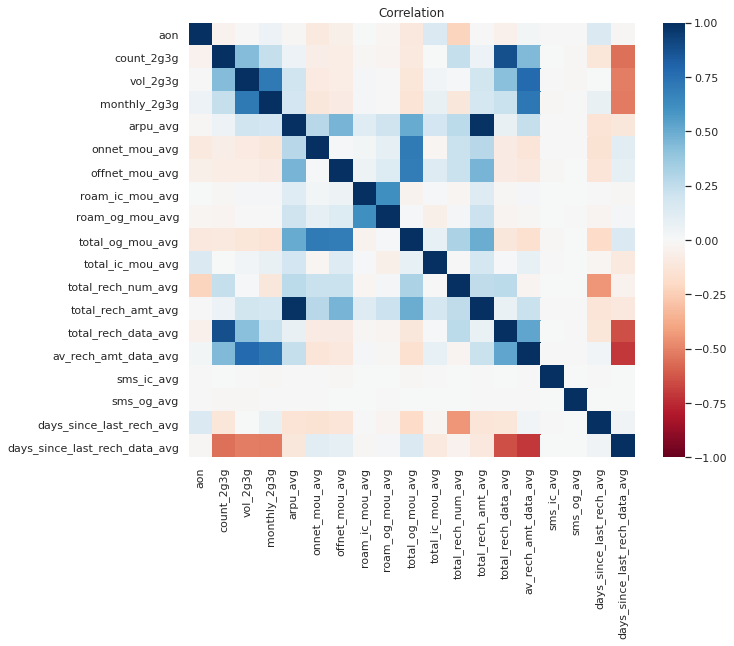

In [ ]:
plt.figure(figsize= (10,8))
s = sns.heatmap(corr,
               annot=False,
               cmap = 'RdBu',
               vmin = -1,
               vmax = 1)
plt.title("Correlation")
plt.show()

### **Normalisation**

In [ ]:
scaler = StandardScaler()
#scaler = MinMaxScaler()
df_std = scaler.fit_transform(df_seg)
df_std = pd.DataFrame(df_std, columns=df_seg.columns)

NameError: ignored

In [ ]:
df_std.head()

NameError: ignored

### **PCA**

In [ ]:
#df_std = df_seg
pca = PCA()
pca.fit(df_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([20.87, 38.48, 48.12, 56.27, 62.24, 67.52, 72.78, 77.91, 82.63,
       86.74, 90.38, 93.08, 95.26, 97.23, 98.56, 99.44, 99.92, 99.99,
       99.99])

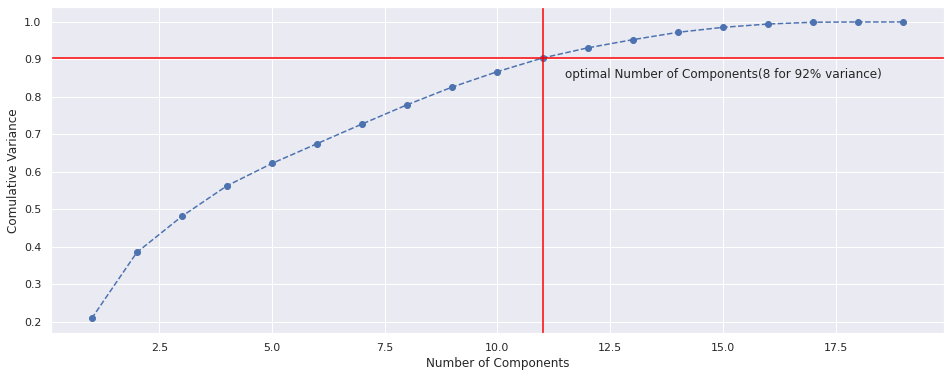

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(range(1,df_seg.columns.size+1), pca.explained_variance_ratio_.cumsum(), marker ='o', linestyle= '--' )
plt.xlabel('Number of Components')
plt.ylabel('Comulative Variance')
plt.axvline(x=11,c ='red')
plt.axhline(y=0.9038, c = 'red')
plt.annotate(s ='optimal Number of Components(8 for 92% variance)' ,xy=[11,0.9038], xytext = (11.5, 0.85))
plt.show()


In [ ]:
componentsNbr = 11
pca  = PCA(n_components = componentsNbr)
pca.fit(df_std)

PCA(copy=True, iterated_power='auto', n_components=11, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

#### Choose PCA components number :

In [ ]:
componentsNames = []
for i in range(1,componentsNbr+1):
  componentsNames.append('Component '+str(i)) 

df_pca = pd.DataFrame(data = pca.components_,
                     columns = df_std.columns.values,
                      index = componentsNames)
df_pca.shape

(11, 19)

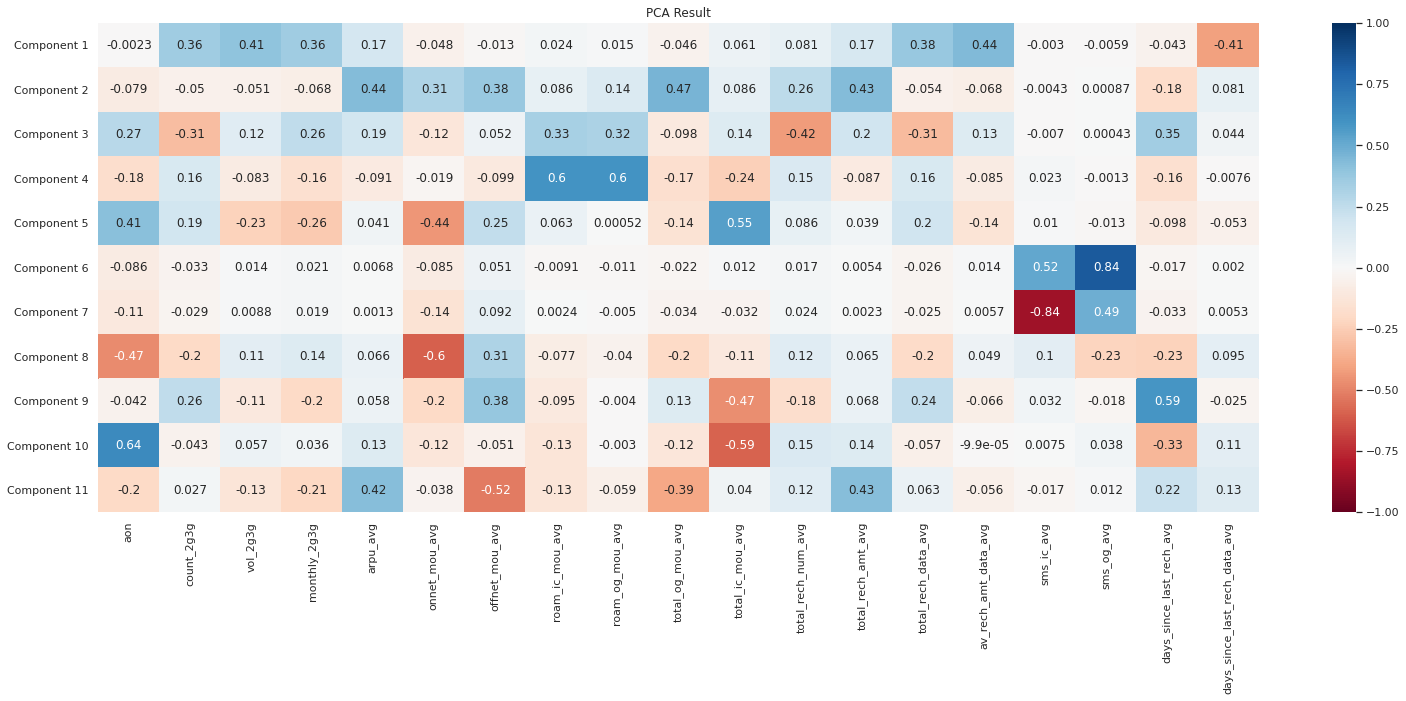

In [ ]:
plt.figure(figsize= (26,9))
s = sns.heatmap(df_pca,
               annot=True,
               cmap = 'RdBu',
               vmin = -1,
               vmax = 1)
plt.title("PCA Result")
plt.show()

In [ ]:
df_pca = pca.transform(df_std)
df_pca = pd.DataFrame(data=df_pca, columns = componentsNames)
print(df_pca.shape)
df_pca.head()

(38744, 11)


,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Component 9,Component 10,Component 11
0,-2.27,-1.62,0.03,0.36,-0.79,1.16,1.04,0.11,0.50,-0.25,0.30
1,0.51,3.77,-0.49,-0.33,-0.69,0.05,-1.04,0.90,0.31,0.29,0.86
2,2.05,0.96,0.66,1.02,-1.41,-0.14,-1.17,0.07,-0.54,-0.07,-0.46
3,4.46,-0.94,0.98,-0.45,-1.33,0.11,-0.06,1.53,-0.52,0.32,-1.11
4,19.52,-5.31,4.76,-3.16,-5.68,1.81,0.60,2.42,-3.06,2.05,-0.11


### **Kmeans**

In [ ]:
wcss = []
kmeans_silhouette=[]
kmeans_db=[]
kmeans_ch=[]

for i in range(1,11):
    kmeans = KMeans(n_clusters= i , init = "k-means++", random_state = 42)
    preds = kmeans.fit_predict(df_pca)
    wcss.append(kmeans.inertia_)

    if(i>1):
      score = silhouette_score(df_pca, preds)
      kmeans_silhouette.append(score)
      score = davies_bouldin_score(df_pca, preds)
      kmeans_db.append(score)
      score = calinski_harabasz_score(df_pca, preds)
      kmeans_ch.append(score)

Text(0, 0.5, 'WCSS')

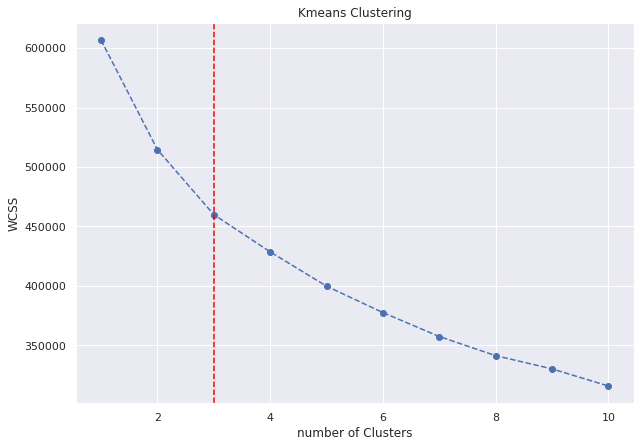

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(range(1,len(wcss)+1), wcss, marker = 'o', linestyle = '--')
plt.axvline(x=3,c ='red',linestyle="--")
plt.title('Kmeans Clustering')
plt.xlabel('number of Clusters')
plt.ylabel('WCSS')
#plt.show()

### **Hierarchical Clustering**

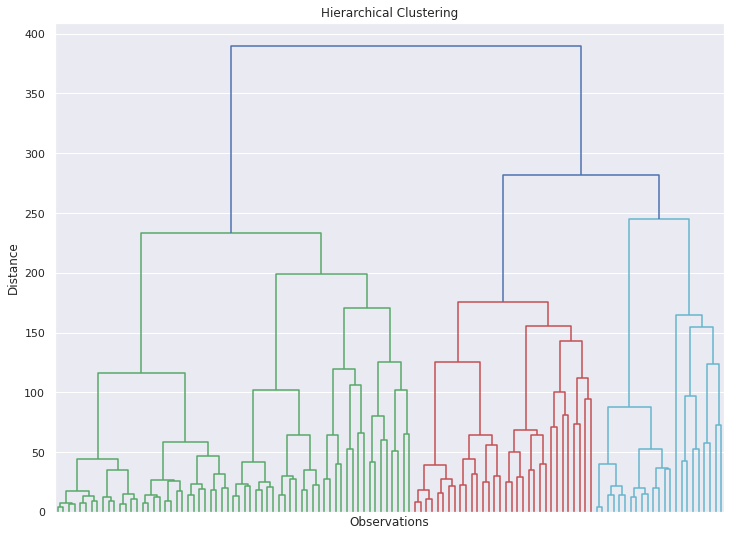

In [ ]:
hCluster = linkage(df_pca,method='ward')
plt.figure(figsize= (10,9))
plt.title("Hierarchical Clustering")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hCluster,
           truncate_mode= "level",
           p = 6,
          show_leaf_counts = False,
          no_labels = True,
          )
plt.show()

In [ ]:
#import scipy.cluster.hierarchy as sch
Agglomerative_silhouette = []
Agglomerative_db = []
Agglomerative_ch = []

for i in range(1,11):
  Agglomerative = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')
  Agglomerative.fit(df_pca)
  labels = Agglomerative.labels_
  
  if(i>1):
      score = silhouette_score(df_pca, labels)
      Agglomerative_silhouette.append(score)
      score = davies_bouldin_score(df_pca, labels)
      Agglomerative_db.append(score)
      score = calinski_harabasz_score(df_pca, labels)
      Agglomerative_ch.append(score)

### **Evaluation:** using Silhouette, Davies–Bouldin index, Calinski-Harabasz Index 

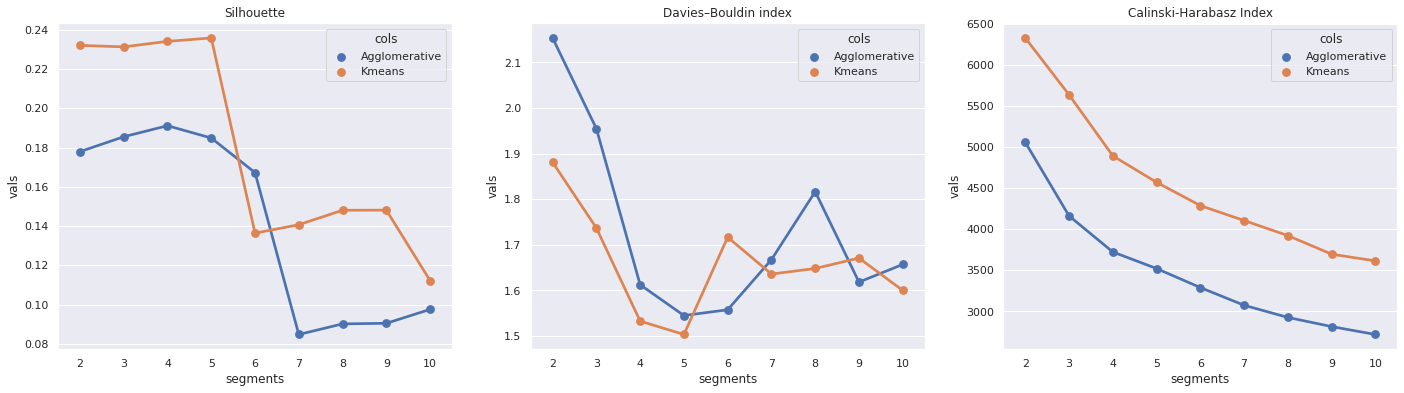

In [ ]:
silhouette = pd.DataFrame({'segments': range(2,11), 'Agglomerative': Agglomerative_silhouette, 'Kmeans': kmeans_silhouette})
db = pd.DataFrame({'segments': range(2,11), 'Agglomerative': Agglomerative_db, 'Kmeans': kmeans_db})
ch = pd.DataFrame({'segments': range(2,11), 'Agglomerative': Agglomerative_ch, 'Kmeans': kmeans_ch})
silhouette = silhouette.melt('segments', var_name=  'cols', value_name =  'vals')
db = db.melt('segments', var_name = 'cols', value_name = 'vals')
ch = ch.melt('segments', var_name = 'cols', value_name = 'vals')

evall = [silhouette, db, ch]
fig , axes = plt.subplots(1,3, figsize = (24,6))
title = ['Silhouette', 'Davies–Bouldin index', 'Calinski-Harabasz Index']
for i,values in enumerate(evall):
    ax = sns.pointplot(x = 'segments', y = 'vals', hue = 'cols', data = values, ax = axes[i])
    ax.set_title(title[i])
plt.show()

### **K-means with n_clusters = 3**

In [ ]:
segmentNbr = 3

segmentsNames = []
for i in range(1,segmentNbr+1):
  segmentsNames.append('Segment '+str(i)) 

kmeans_pca = KMeans(n_clusters= segmentNbr , init = "k-means++", random_state = 42)
kmeans_pca.fit(df_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [ ]:
df_kmeans = df_seg.copy()
#df_kmeans = pd.concat([df_seg.reset_index(drop=True), df_pca],axis=1)
df_kmeans["segment"] = kmeans_pca.labels_+1

### **Descriptive Analyse by Segment**

In [ ]:
df_kmeans.groupby(['segment']).mean()

,aon,count_2g3g,vol_2g3g,monthly_2g3g,arpu_avg,onnet_mou_avg,offnet_mou_avg,roam_ic_mou_avg,roam_og_mou_avg,total_og_mou_avg,total_ic_mou_avg,total_rech_num_avg,total_rech_amt_avg,total_rech_data_avg,av_rech_amt_data_avg,sms_ic_avg,sms_og_avg,days_since_last_rech_avg,days_since_last_rech_data_avg
segment,,,,,,,,,,,,,,,,,,,
1,36.23,0.29,61.11,0.06,978.40,735.33,885.66,29.09,58.20,1567.88,389.11,17.91,1152.55,0.56,41.92,15.59,13.79,2.00,45.96
2,45.45,1.58,551.31,0.47,548.90,130.16,252.34,11.65,13.42,370.78,339.87,10.68,639.43,2.88,257.92,15.61,13.82,3.94,13.06
3,41.28,0.12,12.53,0.02,372.61,193.11,279.00,11.66,16.92,457.13,235.34,9.05,437.66,0.25,17.38,15.73,13.84,4.67,53.13


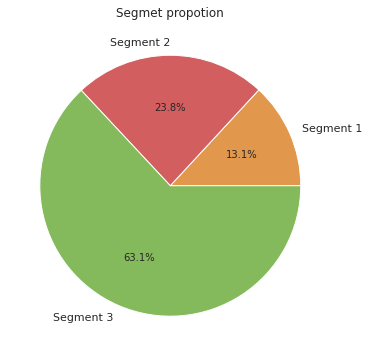

In [ ]:
colors = ['#e1974c','#d35e60','#84ba5b']
seg_prop_count = df_kmeans[['segment',"aon"]].groupby(['segment']).count()
plt.figure(figsize=(9,6))
plt.pie(seg_prop_count,
       autopct="%1.1f%%",
       labels= segmentsNames,
        colors=colors)
plt.title("Segmet propotion")
plt.show()

In [ ]:
seg_prop_sum = df_kmeans[["segment","arpu_avg"]].groupby(["segment"]).sum()
seg_prop_sum.columns = ["ARPU"]
seg_prop_sum["RECH"] = df_kmeans[["segment","total_rech_num_avg"]].groupby(["segment"]).sum()
seg_prop_sum["RECH_DATA"] = df_kmeans[["segment","count_2g3g"]].groupby(["segment"]).sum()
seg_prop_sum["VOL_DATA"] = df_kmeans[["segment","vol_2g3g"]].groupby(["segment"]).sum()
seg_prop_sum["Calls og"] = df_kmeans[["segment","total_og_mou_avg"]].groupby(["segment"]).sum() 
seg_prop_sum["Calls ic"] = df_kmeans[["segment","total_ic_mou_avg"]].groupby(["segment"]).sum() 
seg_prop_sum["SMS og"] = df_kmeans[["segment","sms_ic_avg"]].groupby(["segment"]).sum() 
seg_prop_sum["SMS ic"] = df_kmeans[["segment","sms_og_avg"]].groupby(["segment"]).sum() 

seg_prop_sum

,ARPU,RECH,RECH_DATA,VOL_DATA,Calls og,Calls ic,SMS og,SMS ic
segment,,,,,,,,
1,4976162.14,91075.33,1453.50,310824.68,7974262.44,1979033.97,79313.67,70121.00
2,5065761.83,98609.00,14611.00,5088037.92,3421895.14,3136677.56,144073.67,127576.33
3,9102609.37,221201.67,3025.00,306053.95,11167227.28,5749119.47,384153.67,338082.00


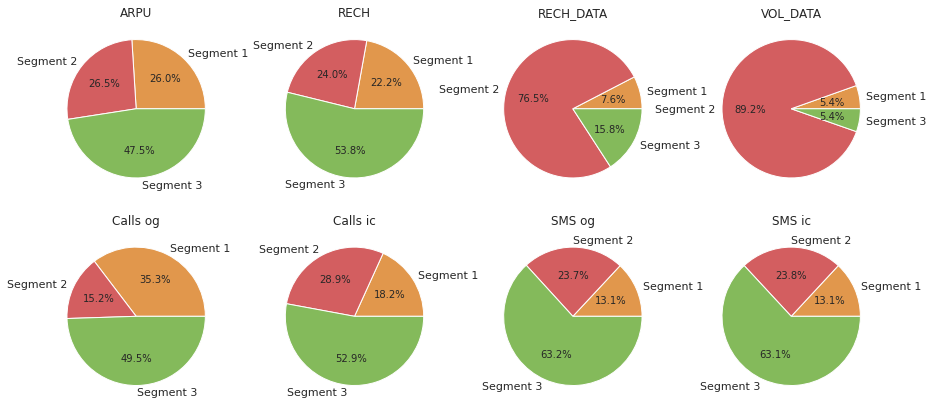

In [ ]:
fig, axes= plt.subplots(2, 4, figsize=(15,7))
for i, ax in enumerate(axes.flatten()):
    ax.pie(seg_prop_sum.iloc[:,i],
       autopct="%1.1f%%",
       radius = 1,
       labels= segmentsNames,
       colors = colors)
    ax.set_title(seg_prop_sum.columns[i])

plt.show()

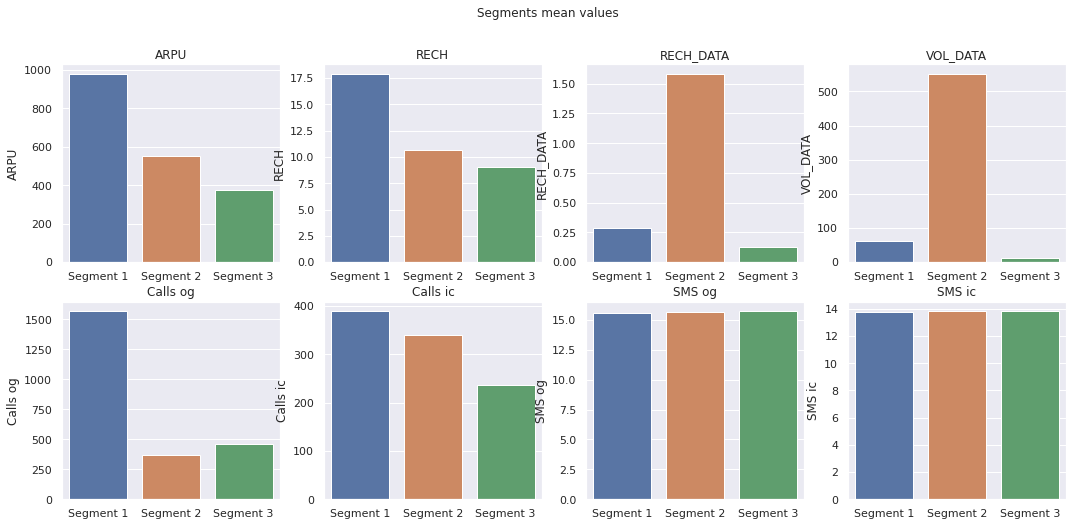

In [ ]:
seg_prop_mean = seg_prop_sum.div(seg_prop_count["aon"],axis="rows") 
col = []
for i in seg_prop_mean.columns:
  col.append(seg_prop_mean[i])

fig,axes = plt.subplots(2,4,figsize = (18,8))
fig.suptitle("Segments mean values")
for i,col in enumerate(col):
    ax = sns.barplot(x= segmentsNames , y = col, ax = axes[int(i/4)][i%4])
    ax.set_title(seg_prop_mean.columns[i])
plt.show()    

### **Export Labeled data**

In [ ]:
data["segment"] = df_kmeans["segment"]

In [ ]:
data.shape

(38744, 52)

In [ ]:
data.to_csv("clustered_dataset.csv")

### **Export Model**

In [ ]:
pickle.dump(scaler,open("scaler.pickle","wb"))

In [ ]:
pickle.dump(pca,open("pca.pickle","wb"))

In [ ]:
pickle.dump(kmeans_pca,open("kmeans_pca.pickle","wb"))